### Use !pip install to download and install necessary packages.

In [1]:
# EXAMPLE -> !pip install keras
# Necessary Packages include -> pandas, plotly, numpy, seaborn, math, keras, sklearn, matplotlib
import numpy as np
import pandas as pd
import plotly.offline as py 
import plotly.graph_objs as go
import seaborn as sns
import math
import keras
import tensorflow

from numpy.random import seed
from tensorflow import set_random_seed
seed = np.random.seed(334)
set_random_seed(seed)

from pandas import DataFrame
from pandas import read_csv
from numpy import concatenate 
from numpy import newaxis
from math import sqrt 
from matplotlib import pyplot 
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import plot_model

py.init_notebook_mode(connected = True)
%matplotlib inline

/Users/omshri96/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


#### Read in Data, Check NAs, Replace

In [52]:
 df = pd.read_csv('data_lstm2.txt', sep = '|')
df['REVENUE'].replace(np.nan, 0, inplace = True)
df['REVENUE'].fillna(method = 'ffill', inplace = True)

uniquecust = list(df.CUSTOMER_CODE.unique())
uniquecust

#df.isnull().values.sum()
#df = df.replace(np.nan, 0, regex=True)
#df.to_csv('data_lstm2.txt', sep = '|', index = False)

,CUSTOMER_CODE,WEEK_ID,REVENUE
0,Cust1,201501,0.00
1,Cust1,201502,284194.10
2,Cust1,201503,591105.38
3,Cust1,201504,230377.56
4,Cust1,201505,233106.22
5,Cust1,201506,642460.76
6,Cust1,201507,441891.09
7,Cust1,201508,306801.96
8,Cust1,201509,99172.28
9,Cust1,201510,524748.94


#### Choose 1 Customer

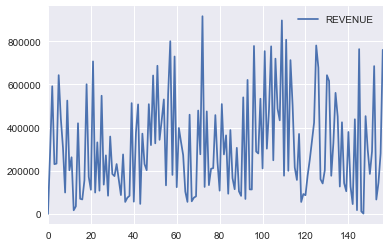

In [26]:
df2 = df[df['CUSTOMER_CODE'] == 'Cust1']
df2 = df2[0:157]
df2 = df2.reset_index()
df2.plot(y='REVENUE')


#### Normalize/Scale Data 

In [27]:
values = df2['REVENUE'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

#### Train/Test Split || It's set to 70/30 but can change below 

In [28]:
train_size = int(len(scaled) * .7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size, :], scaled[train_size:len(scaled),:]

print(len(train), len(test))

109 48


#### Function that Creates Dataset with Look Back. Set Lookback to Desired Amount > 1

In [6]:
look_back = 5
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

103
42


#### Reshape array into 3-D array [samples, timesteps, features]   ||| 

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(103, 5, 1) (103,) (42, 5, 1) (42,)


### Fit Model | Set Neurons w/ Layers

In [8]:
layers = [100,55,50,1]

def create_model(stateful):
    model = Sequential()
    
    model.add(LSTM(
        units = layers[0],
        return_sequences = True,
        batch_input_shape = (1, trainX.shape[1], trainX.shape[2]),
        stateful = stateful 
    ))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        units=layers[1], 
        return_sequences = True,
        stateful = stateful
    ))        
    model.add(Dropout(0.3))

    model.add(LSTM(
        units=layers[2],
        return_sequences = True,    
        stateful = stateful
    ))
    model.add(Flatten())
    
    model.add(Dense(
        units = layers[3],
        activation = 'linear'))
    
    model.compile(loss = 'mae', optimizer = 'adam')   
    return model

print('Creating Stateful Model..')
model_stateful = create_model(stateful = True)

Creating Stateful Model..


### Set Epochs, Keep Batch_Size = 1

In [10]:
epochs = 200
batch_size = 1
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    model_stateful.fit(trainX,
              trainY,
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              #validation_data=(testX, testY),
              shuffle=False)
    model_stateful.reset_states()

Epoch 1 / 200
Epoch 1/1
103/103 [==============================] - 4s 36ms/step - loss: 0.2115
Epoch 2 / 200
Epoch 1/1
103/103 [==============================] - 1s 9ms/step - loss: 0.2159
Epoch 3 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.2092
Epoch 4 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.2113
Epoch 5 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.2046
Epoch 6 / 200
Epoch 1/1
103/103 [==============================] - 1s 12ms/step - loss: 0.2053
Epoch 7 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.2041
Epoch 8 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.2070
Epoch 9 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.2055
Epoch 10 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.2044
Epoch 11 / 200
Epoch 1/1
103/103 [================

103/103 [==============================] - 1s 9ms/step - loss: 0.1492
Epoch 87 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1526
Epoch 88 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1515
Epoch 89 / 200
Epoch 1/1
103/103 [==============================] - 1s 9ms/step - loss: 0.1473
Epoch 90 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.1463
Epoch 91 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.1424
Epoch 92 / 200
Epoch 1/1
103/103 [==============================] - 1s 12ms/step - loss: 0.1507
Epoch 93 / 200
Epoch 1/1
103/103 [==============================] - 1s 12ms/step - loss: 0.1497
Epoch 94 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.1521
Epoch 95 / 200
Epoch 1/1
103/103 [==============================] - 1s 11ms/step - loss: 0.1433
Epoch 96 / 200
Epoch 1/1
103/103 [==============================] -

103/103 [==============================] - 1s 13ms/step - loss: 0.1189
Epoch 172 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1193
Epoch 173 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1211
Epoch 174 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1099
Epoch 175 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1124
Epoch 176 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1151
Epoch 177 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1092
Epoch 178 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1134
Epoch 179 / 200
Epoch 1/1
103/103 [==============================] - 1s 10ms/step - loss: 0.1072
Epoch 180 / 200
Epoch 1/1
103/103 [==============================] - 1s 9ms/step - loss: 0.1014
Epoch 181 / 200
Epoch 1/1
103/103 [======================

#### Predict on Train/Test Sets, RMSE, Inverse Values to Original

In [11]:
trainPredict = model_stateful.predict(trainX, batch_size = batch_size)
rmse_train = sqrt(mean_squared_error(trainPredict, trainY))
print('Train RMSE: %.3f' % rmse_train)

trainPredict2 = scaler.inverse_transform(trainPredict)
trainY2 = scaler.inverse_transform([trainY])

testPredict = model_stateful.predict(testX, batch_size = batch_size)
rmse_test = sqrt(mean_squared_error(testPredict, testY))
print('Test RMSE: %.3f' % rmse_test)

testPredict2 = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

Train RMSE: 0.144
Test RMSE: 0.289


#### Plot Train and Test 

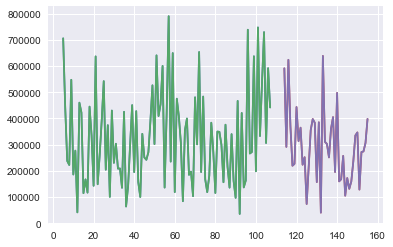

In [103]:
df3 = df2[['REVENUE', 'WEEK_ID']]

# Set Train predictions array for plotting
trainPredictPlot = np.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# # Shift test predictions array for plotting
testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict2)+(look_back*2)+1:len(df3)-1, :] = testPredict2

# Plot baseline and predictions
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)

#pyplot.savefig('train+test_FARBEST.png')

#### Plot Historical Data for Comparison

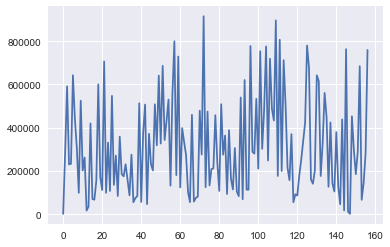

In [15]:
# Kept the 2 plots separate, less messy to look at but feel free to move this one up into other cell
pyplot.plot(df3['REVENUE'])

### Forecasting Future Values (Beyond the Train/Test Set)

In [117]:
curr_frame = testX[0]
predicted = []

for i in range(len(testX)):                                                     
    predicted.append(model_stateful.predict(curr_frame[newaxis,:,:], batch_size = batch_size)[0,0]) 
    
    
    curr_frame = curr_frame[1:]                                                  
    curr_frame = np.insert(curr_frame, len(testX[0])-1, predicted[-1], axis = 0)

SyntaxError: 'return' outside function (<ipython-input-117-1651dcef634c>, line 9)

In [102]:
testPredict = model_stateful.predict(testX, batch_size = batch_size)

In [114]:
curr_frame

array([[ 0.53528327],
       [ 0.22574435],
       [ 0.50214088],
       [ 0.83574009],
       [ 0.20226277]], dtype=float32)

#### Create X-Axis for Predicted vs. Actual, Plot

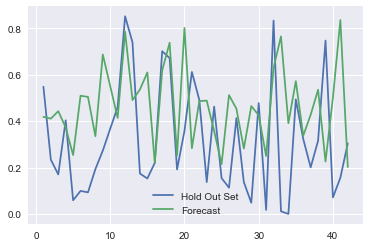

In [107]:
N = len(testX)
xtestval = pd.DataFrame({'Time': range(1,N+1,1)})

pyplot.plot(xtestval, testY, label = 'Hold Out Set')
pyplot.plot(xtestval, predicted, label = 'Forecast')
pyplot.legend()

#pyplot.savefig('stateful_3layerLSTM.png')

In [109]:
# print(np.mean(testX))
# print(np.mean(predicted))

0.343001
0.466535
